<a href="https://colab.research.google.com/github/savarova/Federated-Learning-on-CIFAR10/blob/main/Implement_Federated_Learning_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Take Home Assignment - Federated Learning for Image Classification

**Please note that a description of the task, this code, and the results can be found in the attached pdf-file.**

To run the full code, choose above *Runtime* and then *Run all*. To run a cell by itself, choose the cell by clicking on it and the press either the combination cntr+Enter on your keyboard or the small *play* button in the upper left corner of the cell.

In [1]:
!pip install flwr
!pip install -U "flwr[simulation]"
!pip install flwr_datasets

In [ ]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.client.mod import fixedclipping_mod
from flwr_datasets.partitioner import IidPartitioner
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad, DifferentialPrivacyClientSideFixedClipping
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context, Metrics

In [ ]:
'''
Parameters for customization of the code.

-NUM_PARTITIONS defines the number of clients. 5 clients run in about 20 minutes, 10 clients run in about 35 minutes.
-If DIFFERENTIAL_PRIVACY is set to True, it will activate the differential privacy strategy.However, this function has not yet been fully developed
and thus hinders significantly the learning of the model.
-If CONFUSION_MATRIX is set to True, the evaluate function will call to plot the confusion matrix at the end of each round.
-If the VERBOSE parameter is set to False, the client's training function will not print the training accuracy and loss.
-There is a possibility to change the type of torch.devise to allocate more resources for the computation, however, it is not advisable on Google Colab notebook.
-The BATCH_SIZE should not be changed.
'''

ROUNDS = 5
EPOCHS = 7
NUM_PARTITIONS = 5
DIFFERENTIAL_PRIVACY = False
CONFUSION_MATRIX = True
VERBOSE = False
DEVICE = torch.device("cpu")

#Please do not change this parameter
BATCH_SIZE = 32

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
load_datasets function loads the CIFAR-10 dataset from Flower library and divides the data into training, validation, and test sets.
It is called in client_fn and evaluate functions. In client_fn an IidPartitioner function is used to define the client of the service
and to load training and validation sets without these appearing on the server. In evaluate it is used to download the test dataset onto the server
to evaluate the model's performance at the end of each round. This ensures that no raw data is transfered between the server and clients.

'''

def load_datasets(partition_id: int, num_partitions: int):

    partitioner = IidPartitioner(num_partitions = num_partitions) #Define the client as IID
    fds = FederatedDataset(dataset="cifar10", partitioners = {"train": partitioner}) #Use the CIFAR-10 dataset for training
    partition = fds.load_partition(partition_id) #Partition the data into as many clients as needed

    partition_train_test = partition.train_test_split(test_size=0.2, seed=42) # Divide the data 80% train, 20% test
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    ) #Will turn the data into tensor and normalize it

    def apply_transforms(batch): #This function is used to apply the previously defined transformations
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms) #Applying transformations to training and validation sets

    trainloader = DataLoader(partition_train_test["train"], batch_size = BATCH_SIZE, shuffle=True) #Creating training and validation loaders
    valloader = DataLoader(partition_train_test["test"], batch_size = BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms) #Applying transformations to test set
    testloader = DataLoader(testset, batch_size = BATCH_SIZE) #Creating test loader

    return trainloader, valloader, testloader

In [ ]:
"""
Class Net describes the neural network model used in this code. This model is a standard convolutional neural network with two convolutional (CONV)
layers and three fully connected (FC) layers. After each CONV layer an activation function and pooling layer are applied. After each FC layer an activation
function is applied. For CONV layers I tried kernel sizes 3 and 5, and found that 3 performes better.

I have also added a commented, second, more comprehensive, convolutional neural network model, that I have tested without the federated learning. This
model performs a lot better than the model above it. However, this model is also a lot more computationally heavy, as it has more layers and more neurons,
and only pools every second layer, instead of every other layer. Even without the federated learning, it takes almost 1.5h to run seven epochs, and every time
it has crushed either my laptop or my internet connection. Thus, I have not had the chance to test this model on client simulation. However, if I had
a better equipment, e.g. CSC's supercomputer, this would be the model I would try to implement for this task.

Functions get_parameters and set_parameters are required for federated learning so that clients and the server can access the model's parameters.

The train and test functions are called in FlowerClient's fit function and during the server's evaluate function respectively. The test function is also
responsible for the plotting of the confusion matrix for each round. I used Cross Entropy Loss as a loss function since this is a multi-labels classification
problem. I tried as an optimizer both Adam and Stochastic Gradient Descent, and chose Adam as it performed better. The learning rate used in the optimizer is
0.001 and the weight decay is zero.
"""

class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 32, 3, padding = 1)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x))) #Applying an activation function and pooling to the CONV layer
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8) #Reshaping the tensor for the FC layer
        x = F.relu(self.fc1(x)) #Applying an activation function to the FC layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #No softmax needed as torch's CrossEntropyLoss() already includes one in itself
        return x

# Comprehensive model
# class Net(nn.Module):
#     def __init__(self) -> None:
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
#         self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
#         self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(256 * 4 * 4, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 10)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x = F.relu(self.conv1(x)) #Applying an activation function to the CONV layer
#         x = F.relu(self.conv2(x))
#         x = self.pool(x) #Applying pooling every two CONV + activation layers
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.pool(x)
#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))
#         x = self.pool(x)

#         x = x.view(-1, 256 * 4 * 4)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int, Verbose = True):

    criterion = torch.nn.CrossEntropyLoss() #Loss function
    optimizer = torch.optim.Adam(net.parameters()) #Optimizer

    #Sets the model into a training stage. This is more of a precaution step as the model is set into an evaluating stage after each round.
    net.train()

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0

        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            #Forward pass
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)

            #Backward pass
            loss.backward()
            optimizer.step()

            #Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total

        if Verbose:
          print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader, conf_mat = False):

    criterion = torch.nn.CrossEntropyLoss()

    correct, total, loss = 0, 0, 0.0
    predicted_list = []
    labels_list = []

    #Setting the model into an evaluating stage
    net.eval()

    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            # images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)

            #Metrics
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            #Collect additional metrics for the confusion matrix
            if conf_mat:
              predicted_list += predicted.tolist()
              labels_list += labels.tolist()

            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total

    #Plot confusion matrix
    if conf_mat:
      classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
      ConfusionMatrixDisplay.from_predictions(labels_list, predicted_list, display_labels = classes)

    return loss, accuracy

# The client side

In [ ]:
'''
FlowerClient class defines the client and the main functions used by the client, such as fitting/training the model and evaluating
it on the validation set. The client_fn function loads the training datasets and assigns them to clients. The ClientApp wraps the
FlowerClient and client_fn to be used in the simulation.
'''

class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f'[Client {self.partition_id}] - GETTING PARAMETERS')
        return get_parameters(self.net)

    def fit(self, parameters, config): #Performimg the training
        print(f'[Client {self.partition_id}] - PERFORMIMG TRAINING')
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs = EPOCHS, Verbose = VERBOSE)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config): #Performing the validation
        print(f'[Client {self.partition_id}] - EVALUATING ON VALIDATION SET')
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    #Read the configuration to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


#Create the ClientApp either with differential privacy or without
if DIFFERENTIAL_PRIVACY:
  client = ClientApp(client_fn = client_fn, mods = [fixedclipping_mod])
else:
  client = ClientApp(client_fn = client_fn)

# Evaluation techniques

In [ ]:
'''
Both of these functions are used by the server after every round. The evaluate function is used as an optional validation function
in the server's federation learning strategy. It dowloads the test set using the load_datasets function, performs the validation on the test set and
if needed plots the confusion matrix. The weighted_average is used as an evaluation metrics aggregation function, and it prints the weighted average accuracy.
Both, the normal and weighted accuracies are printed at the end of the simulation in the summary of metrics.
'''

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    #Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    #Aggregate and return weighted average
    return {"Weighted average accuracy": sum(accuracies) / sum(examples)}


def evaluate(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  #Update model with the latest parameters
    loss, accuracy = test(net, testloader, conf_mat = CONFUSION_MATRIX)

    # print(f"Server-side evaluation loss is {loss} and accuracy is {accuracy}")
    return loss, {"Centralized evaluation accuracy": accuracy}

# The server side

In [ ]:
'''
The server_fn function defines the federated learning strategy, i.e., how many clients to use for training and testing,
what parameters to use, and what evaluation functions to use. If DIFFERENTIAL_PRIVACY is set to True, the server_fn will
create a differential privacy strategy around the federated learning strategy. The ServerApp wraps the information to be used in simulation.
'''

def server_fn(context: Context) -> ServerAppComponents:

    #Create Federated Average strategy
    strategy = FedAvg(
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 5,
        min_evaluate_clients = 5,
        min_available_clients = NUM_PARTITIONS,
        initial_parameters = ndarrays_to_parameters(get_parameters(Net())),  #Pass initial model parameters
        evaluate_fn = evaluate,
        evaluate_metrics_aggregation_fn = weighted_average,
    )

    #Configure the server for predetermined number of rounds of training
    config = ServerConfig(num_rounds = ROUNDS)

    if DIFFERENTIAL_PRIVACY == True:
        dp_strategy = DifferentialPrivacyClientSideFixedClipping(
          strategy,
          noise_multiplier = 2.0,
          clipping_norm = 1.0,
          num_sampled_clients = 5,
        )
        return ServerAppComponents(strategy = dp_strategy, config=config)

    else:
        return ServerAppComponents(strategy = strategy, config=config)

#Create ServerApp
server = ServerApp(server_fn = server_fn)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
(pid=6538) 2024-09-16 01:54:17.298464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6538) 2024-09-16 01:54:17.400838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6538) 2024-09-16 01:54:17.429090: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      initial parameters (loss, other metrics): 0.0721612847328186, {'Centralized evaluati

(ClientAppActor pid=6538) [Client 1] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 2] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 3] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 4] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 0] - PERFORMIMG TRAINING


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.05403732635974884, {'Centralized evaluation accuracy': 0.474}, 394.576190538)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 1] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 2] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 3] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 4] - EVALUATING ON VALIDATION SET


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 1] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 2] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 3] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 4] - PERFORMIMG TRAINING


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (2, 0.03638473914861679, {'Centralized evaluation accuracy': 0.613}, 781.8977363030001)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 1] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 2] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 3] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 4] - EVALUATING ON VALIDATION SET


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 1] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 2] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 3] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 4] - PERFORMIMG TRAINING


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (3, 0.04577143405675888, {'Centralized evaluation accuracy': 0.6323}, 1164.885997695)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 1] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 2] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 3] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 4] - EVALUATING ON VALIDATION SET


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 1] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 2] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 3] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 4] - PERFORMIMG TRAINING


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (4, 0.052758886700868604, {'Centralized evaluation accuracy': 0.6268}, 1553.074683132)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 1] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 2] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 3] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 4] - EVALUATING ON VALIDATION SET


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 1] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 2] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 3] - PERFORMIMG TRAINING
(ClientAppActor pid=6538) [Client 4] - PERFORMIMG TRAINING


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (5, 0.05533058029413223, {'Centralized evaluation accuracy': 0.6234}, 1937.093033214)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=6538) [Client 0] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 1] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 2] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 3] - EVALUATING ON VALIDATION SET
(ClientAppActor pid=6538) [Client 4] - EVALUATING ON VALIDATION SET


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1951.13s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05454706723690032
INFO :      		round 2: 0.0369640956223011
INFO :      		round 3: 0.04628399629294873
INFO :      		round 4: 0.053732868605852135
INFO :      		round 5: 0.05632149281799793
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0721612847328186
INFO :      		round 1: 0.05403732635974884
INFO :      		round 2: 0.03638473914861679
INFO :      		round 3: 0.04577143405675888
INFO :      		round 4: 0.052758886700868604
INFO :      		round 5: 0.05533058029413223
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'Weighted average accuracy': [(1, 0.4755),
INFO :      	                               (2, 0.6114),
INFO :      	                               (3, 0.6314000000000001),
INFO :      	                               (4, 0.6267),

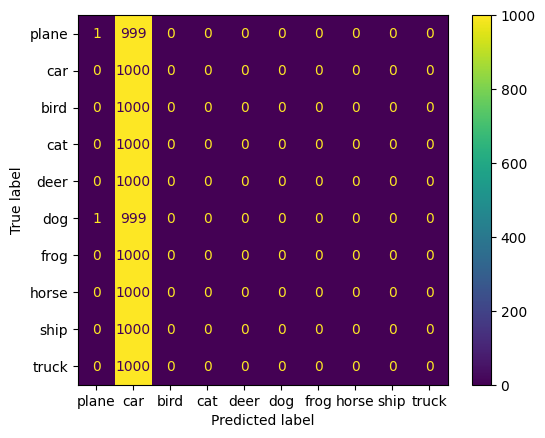

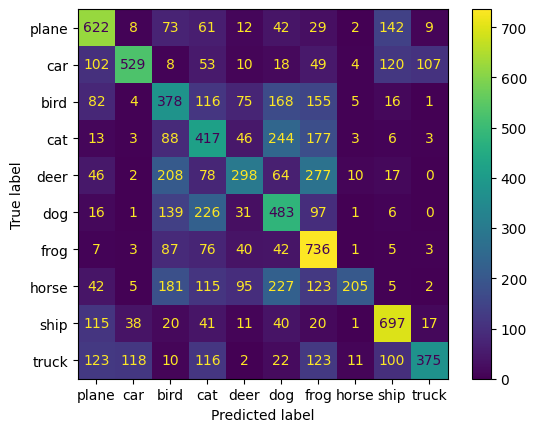

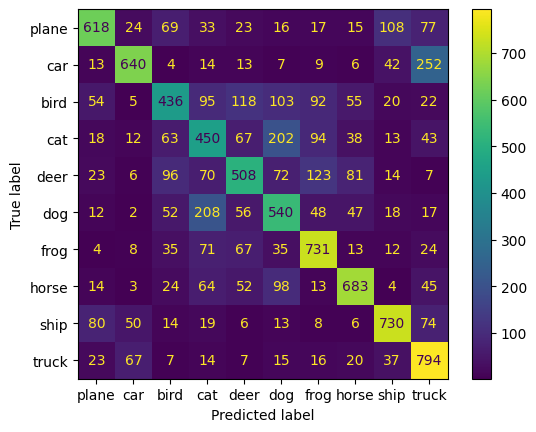

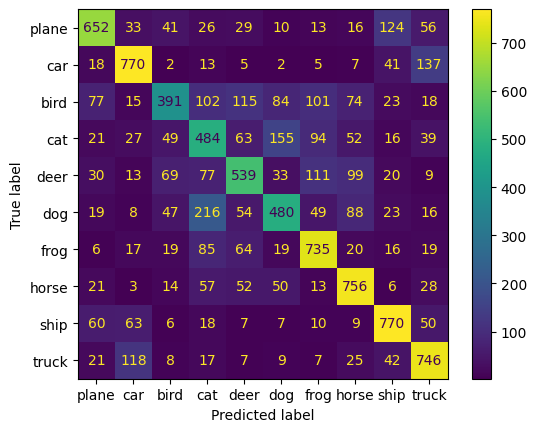

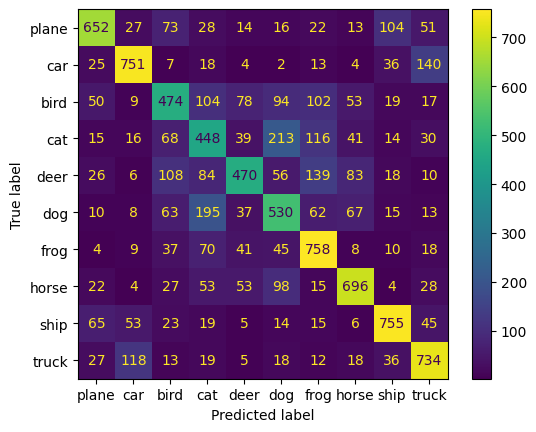

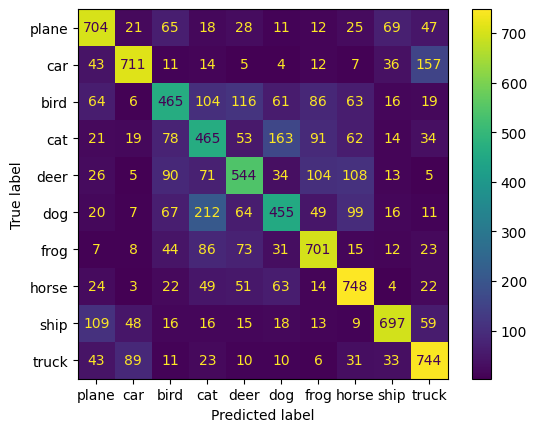

In [ ]:
#Defining what resources clients can use. I allocate the minimum, as to not crash the Colab notebook.
backend_config = {"client_resources": None}
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_gpus": 1}}

#Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)